# google drive link to [data](https://drive.google.com/drive/folders/1eMPEZiL5zGS9hgIZcUzffj-tvUA766dx?usp=sharing)

# Antarctica's Digital Twin: Exploratory Data Analysis (EDA)

* This notebook explores a high-resolution, multimodal dataset fusing laser altimetry, gravity fields, ocean thermodynamics, and sub-glacial topography across the Antarctic continent (2019–2025)
* The goal is to provide a "physics-ready" feature space for machine learning models predicting ice sheet instability.

## 1. Dataset Descriptions

### Ocean Data (GLORYS12V1)

* Description: A global ocean reanalysis product providing 3D physical variables (temperature, salinity) at 1/12° resolution.
* Why Included: Ocean thermal forcing is the primary driver of basal melting under ice shelves. We need to know if the water touching the ice is warm (Modified Circumpolar Deep Water) or cold
* [more info here](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description)

### Gravity Data (GRACE-FO)

* Description: The Gravity Recovery and Climate Experiment (Follow-On) mission measures changes in Earth's gravity field caused by mass redistribution.
* Why Included: While ICESat-2 measures volume change (geometry), GRACE measures mass change. It provides the broad-scale context (~25km resolution) that validates whether thinning is due to ice loss or snow compaction
* [more info here](https://gracefo.jpl.nasa.gov/data/grace-fo-data/)

### Sub-Glacial Topography (Bedmap)

* Description: The definitive map of Antarctica's bedrock and ice thickness, compiling decades of radar and seismic surveys.
* Why Included: Geometry dictates flow. "Retrograde beds" (slopes that get deeper inland) are mechanically unstable (Marine Ice Sheet Instability). We need the bed shape to predict collapse risk.
* [more info here](https://scar.org/science/excom/bedmap3)

### Altimetry Data (ICESat-2)

* Description: The Advanced Topographic Laser Altimeter System (ATLAS) measures surface height with centimeter-level precision.
* Why Included: This is our Target Variable. We are trying to predict/analyze delta_h (surface height change) to track the thinning of the ice sheet over time.
* [more info here](https://nsidc.org/data/icesat-2)
  * [data product info](https://nsidc.org/data/icesat-2/products)
  * [ATL15 ino](https://nsidc.org/data/atl15/versions/2)


## 2. Data Exploration

* Using pyspark we will scan the parquet to identify the total number of observations (number of rows) and schema (column names)

NOTE: if having trouble with env try running
* `uv run python -m ipykernel install --user --name dsc232_project --display-name "Python (Antarctica)"`

In [2]:
"""
set path to parquet
TODO: add slick download from google drive
* CAUTION: data is several GB it might take a while to grab
"""
dataset_path = "/home/scotty/qad_v2/merged_data"

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, IntegerType
spark = SparkSession.builder.appName("Antarctica_Digital_Twin_EDA").getOrCreate()
# tmp patch until i switch timestamp to us from ns
# note: adjustment because of nanosecond issue will be marked # ns*:
custom_schema = StructType([
    StructField("time", LongType(), True),             
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True),
    StructField("delta_h", DoubleType(), True),
    StructField("misfit_rms", DoubleType(), True),
    StructField("data_count", DoubleType(), True),
    StructField("dhdt_lag1", DoubleType(), True),
    StructField("ice_area", DoubleType(), True),
    StructField("lwe_thickness_cm", DoubleType(), True),
    StructField("land_mask", DoubleType(), True),
    StructField("ocean_mask", DoubleType(), True),
    StructField("dist_to_ocean_km", DoubleType(), True),
    StructField("so", DoubleType(), True),
    StructField("thetao", DoubleType(), True),
    StructField("depth", DoubleType(), True),
    StructField("mask", DoubleType(), True),            
    StructField("surface_topography", DoubleType(), True),
    StructField("bed_topography", DoubleType(), True),
    StructField("ice_thickness", DoubleType(), True)
])

# ns**: read with the explicit schema
df_raw = spark.read.schema(custom_schema).parquet(dataset_path)

# ns**: convert to seconds
df = df_raw.withColumn(
    "time", 
    F.to_date((F.col("time") / 1_000_000_000).cast("timestamp"))
)

# get row count 
dataset_row_count = df.count()

# get column names
column_names = df.columns

print(f"TOTAL ROWS in Digital Twin: {dataset_row_count:,}")
print(f"COLUMN COUNT: {len(column_names)}")
print(f"columns: {column_names}")

TOTAL ROWS in Digital Twin: 358,123,293
COLUMN COUNT: 19
columns: ['time', 'x', 'y', 'delta_h', 'misfit_rms', 'data_count', 'dhdt_lag1', 'ice_area', 'lwe_thickness_cm', 'land_mask', 'ocean_mask', 'dist_to_ocean_km', 'so', 'thetao', 'depth', 'mask', 'surface_topography', 'bed_topography', 'ice_thickness']


## 3. Column Reference and Sample Data

* Below is the data dictionary for the fused schema, validated with sample outputs.

### Shared Columns 

* time: Monthly timestamp (YYYY-MM-DD)
* x: X Coordinate in Antarctic Polar Stereographic (EPSG:3031)
* y: Y Coordinate in Antarctic Polar Stereographic (EPSG:3031).

In [17]:
df.select("time", "x", "y").show(5)

+----------+--------+---------+
|      time|       x|        y|
+----------+--------+---------+
|2020-12-31|-11000.0|2250000.0|
|2020-12-31|-17000.0|2249000.0|
|2020-12-31|-21000.0|2247000.0|
|2020-12-31| -1000.0|2247000.0|
|2020-12-31|-36000.0|2246000.0|
+----------+--------+---------+
only showing top 5 rows


### IceSat-2 Columns

High-resolution laser altimetry providing the primary signal for ice sheet change

* delta_h: change in surface height change (m)
  * Negative = Thinning
* misfit_rms: quality metric. Root Mean Square of the fit
  * can be used for weighting each point( learn more from high quality points) 
* data_count: density of laser shots per pixel
  * can be used for weighting each point(learn more from high quality points)  
* dhdt_lag1: quartly average of height change
* ice_area: effective area of ice within the pixel

In [9]:
df.select("delta_h", "misfit_rms", "data_count", "dhdt_lag1", "ice_area").show(5)

+----------------+----------------+--------------+---------+--------------+
|         delta_h|      misfit_rms|    data_count|dhdt_lag1|      ice_area|
+----------------+----------------+--------------+---------+--------------+
| 1.5091552734375|            NULL|          NULL|     NULL|   834885.4375|
|1.92803955078125| 0.1663818359375|1.335205078125|     NULL|101580.8359375|
| 1.6156005859375|            NULL|          NULL|     NULL|   857323.5625|
| 0.0421142578125|            NULL|          NULL|     NULL|     857328.25|
|1.83685302734375|0.14093017578125| 0.09814453125|     NULL| 101596.703125|
+----------------+----------------+--------------+---------+--------------+
only showing top 5 rows


### GRACE-FO Columns

Gravity-derived mass balance

* lwe_thickness_cm: Liquid Water Equivalent thickness change (cm)
* land_mask: GRACE land fraction (0-1)
* ocean_mask: GRACE ocean fraction (0-1)

In [10]:
df.select("lwe_thickness_cm", "land_mask", "ocean_mask").show(5)

+-----------------+---------+----------+
| lwe_thickness_cm|land_mask|ocean_mask|
+-----------------+---------+----------+
|7.286578178405762|      0.0|       1.0|
|7.286578178405762|      0.0|       1.0|
|7.286578178405762|      0.0|       1.0|
|7.286578178405762|      0.0|       1.0|
|7.286578178405762|      0.0|       1.0|
+-----------------+---------+----------+
only showing top 5 rows


### Bedmap Columns

Static sub-glacial topography 

**note: bedrock does not change with time but ice thickness does at our timescale**

* bed_topography: elevation of the bedrock (meters).
* surface_topography: elevation of the ice surface (meters).
* ice_thickness: total thickness of the ice column
  * use this and delta_h from icesat to propagate ice thickness over time
* mask: categorization of surface type based on grounding status
  * 1 = grounded ice 
  * 2 = transiently grounded ice shelf
  * 3 = floating ice shelf
  * 4 = rock
            

In [11]:
df.select("mask", "bed_topography", "surface_topography", "ice_thickness").show(5)

+----+--------------+------------------+-------------+
|mask|bed_topography|surface_topography|ice_thickness|
+----+--------------+------------------+-------------+
| 3.0|       -1655.0|              33.0|        224.0|
| 3.0|       -1853.0|              33.0|        231.0|
| 3.0|       -2061.0|              31.0|        236.0|
| 3.0|       -1529.0|              31.0|        208.0|
| 3.0|       -2422.0|              29.0|        242.0|
+----+--------------+------------------+-------------+
only showing top 5 rows


### Ocean Columns

Thermodynamic forcing from the GLORYS reanalysis model. 

**Note: Valid only for Floating Ice Shelves (mask=3 or mask=2). Grounded ice will show null**

* thetao: potential seawater temperature $^\circ\text{C}$
* so: eawater salinity (PSU).
* depth: bathymetric depth (meters).
* dist_to_ocean_km:	distance to open ocean front (km).

In [12]:
df.filter(df.mask.isin(2, 3)).select("thetao", "so", "depth", "dist_to_ocean_km").show(5)

+-------------------+------------------+-------------------+------------------+
|             thetao|                so|              depth|  dist_to_ocean_km|
+-------------------+------------------+-------------------+------------------+
|-1.9533371776342392| 33.02560499869287|0.49402499198913574|1.1623817682266235|
|-1.9482100680470467| 33.04849388077855|0.49402499198913574|1.7048115730285645|
| -1.950407400727272|33.056123508140445|0.49402499198913574|3.7842307090759277|
|-1.9694509506225586|32.862330973148346|0.49402499198913574|3.7792739868164062|
|-1.9731131717562675| 33.04696795530617|0.49402499198913574| 4.419100761413574|
+-------------------+------------------+-------------------+------------------+
only showing top 5 rows


## 4. Statistics and Missing Data

### Calculate Totals & Data Scales

- Check the number of observations of the dataset 
- Check the distribution of physical variables 

In [ ]:
# check observations
total_obs = df.count()
print(f"Total Observations: {total_obs:,}")

# check variables for physics and geometry
target_cols = ['delta_h', 'lwe_thickness_cm', 'thetao', 'bed_topography']
df.select(target_cols).describe().show()

Total Observations: 358,123,293
>>> Variable Summaries (Min/Max/Mean):


+-------+--------------------+-------------------+-------------------+-------------------+
|summary|             delta_h|   lwe_thickness_cm|             thetao|     bed_topography|
+-------+--------------------+-------------------+-------------------+-------------------+
|  count|           357264369|          358123293|           41006873|          358123293|
|   mean|0.043600323263705894|-14.334551127793382|-1.1617948857442435|-30.964037860000353|
| stddev|  0.7613113538265814| 127.54529475237479| 1.3033209916769302|  694.1589337849063|
|    min|     -63.59619140625| -1679.893310546875| -2.888668455183506|            -3013.0|
|    max|   83.06915283203125|  308.6047058105469|  6.961241506040096|             4198.0|
+-------+--------------------+-------------------+-------------------+-------------------+



### Missing Data

- Calculate the ratio of missing values for every column
- **Note: High missingness in thetao (Ocean Temp) is expected, as this variable is only defined for floating ice shelves(mask=3 or mask=2)**

In [ ]:
# Helper function to calculate missing ratios safely 
# note: probably something weird when writting fusion dataset(ocean+icesat+grace+bedmap)
# TODO: needs optimization kinda slow..this just get working grab
def count_missings(spark_df):
    total = spark_df.count()
    exprs = []
    for c, dtype in spark_df.dtypes:
        if dtype in ('double', 'float'):
            expr = F.count(F.when(F.isnan(c) | F.col(c).isNull(), c))
        else:
            expr = F.count(F.when(F.col(c).isNull(), c))
        exprs.append((expr / total).alias(c))
    return spark_df.select(exprs)

missing_ratios = count_missings(df).collect()[0].asDict()

for col, ratio in missing_ratios.items():
    if ratio > 0.01: 
        print(f"  - {col}: {ratio:.1%} missing")

  - misfit_rms: 8.8% missing
  - data_count: 8.8% missing
  - dhdt_lag1: 7.9% missing
  - dist_to_ocean_km: 88.5% missing
  - so: 88.5% missing
  - thetao: 88.5% missing
  - depth: 88.5% missing


#### Comments

* again ocean fine, there is limited area where it is defined(basically does ocean touch ice)

#### TODO
* check missing dates in netCDF files i think that will account for ~8% icesat missing

## 5. Plots: Distributions, Scatter Plots, Feature Importance

### Distributions: Histogram

Calculating full-data histogram for delta_h...


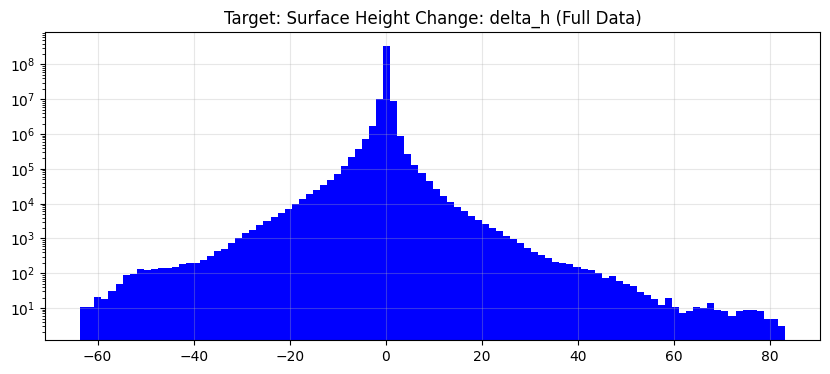

Calculating full-data histogram for dhdt_lag1...


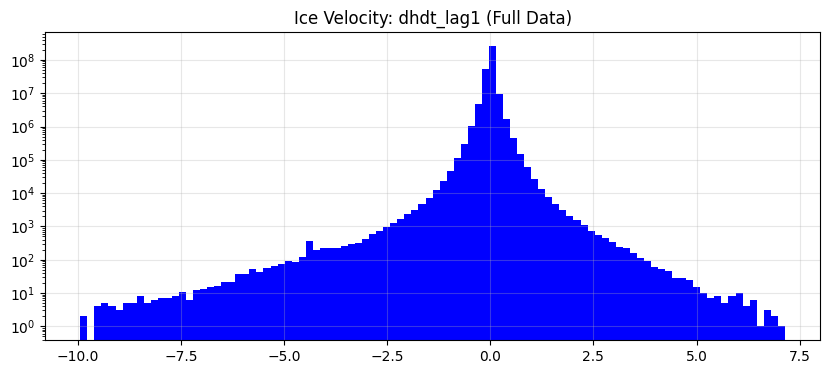

Calculating full-data histogram for so...


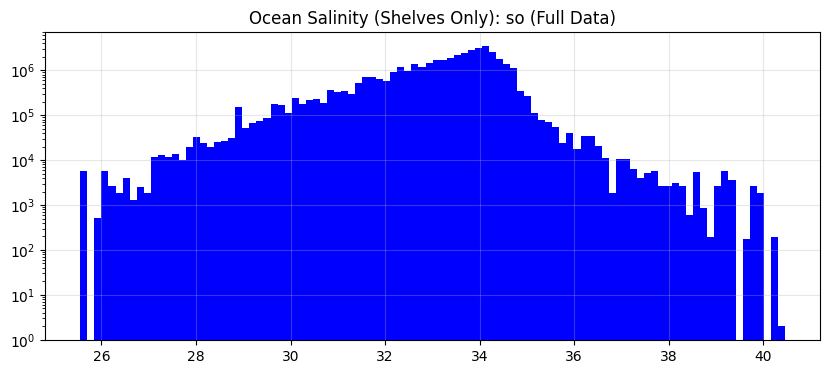

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spark_dist(df, col, bins=100, title="Distribution"):
    print(f"Calculating full-data histogram for {col}...")
    
    # get min and max
    mm = df.select(F.min(col), F.max(col)).first()
    mn, mx = mm[0], mm[1]
    
    # set step size
    step = (mx - mn) / bins
    
    # assign bins
    hist_df = df.select(col).dropna().withColumn(
        "bin_id", 
        F.floor((F.col(col) - mn) / step).cast("int")
    )
    
    # spark agg
    result = hist_df.groupBy("bin_id").count().orderBy("bin_id").collect()
    
    # piece together for plotting
    counts_dict = {row['bin_id']: row['count'] for row in result}
    

    if bins in counts_dict:
        counts_dict[bins-1] = counts_dict.get(bins-1, 0) + counts_dict[bins]
        del counts_dict[bins]
        
    
    counts = [counts_dict.get(i, 0) for i in range(bins)]
    edges = np.linspace(mn, mx, bins+1)
    
    # plot
    plt.figure(figsize=(10, 4))
    plt.bar(edges[:-1], counts, width=step, align='edge', color='blue')
    plt.yscale('log')
    plt.title(f"{title}: {col} (Full Data)")
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage

plot_spark_dist(df, 'delta_h', title="Target: Surface Height Change")
plot_spark_dist(df, 'dhdt_lag1', title="Ice Velocity")
plot_spark_dist(df.filter("mask=3"), 'so', title="Ocean Salinity (Shelves Only)")

### Scatter Plots

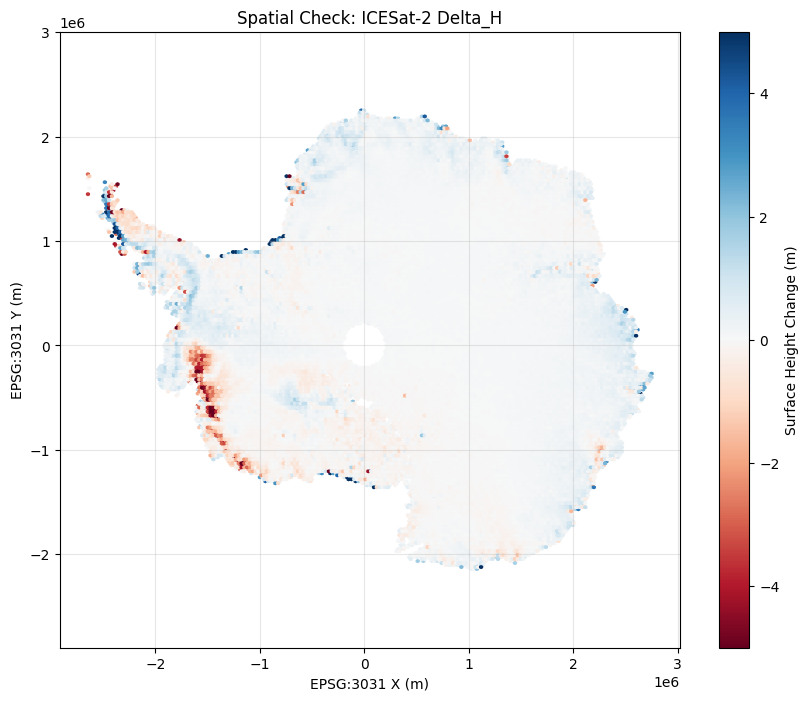

In [32]:
from pyspark.sql.functions import col

# sample 0.001
sample_pdf = df.select("x", "y", "delta_h") \
               .dropna() \
               .sample(fraction=0.001, seed=42) \
               .toPandas()


plt.figure(figsize=(10, 8))


# plot
hb = plt.hexbin(
    sample_pdf['x'], 
    sample_pdf['y'], 
    C=sample_pdf['delta_h'],
    gridsize=200,          
    cmap='RdBu',           
    reduce_C_function=np.mean, 
    vmin=-5, vmax=5        
)

# plt args/style
cb = plt.colorbar(hb, label='Surface Height Change (m)')
plt.title("Spatial Check: ICESat-2 Delta_H")
plt.xlabel("EPSG:3031 X (m)")
plt.ylabel("EPSG:3031 Y (m)")
# 'equal' axis is CRITICAL for spatial plots to avoid distortion
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.show()

### First Winter vs Last Winter

2019 winter subset points: 132,308


2024 winter subset points: 132,513


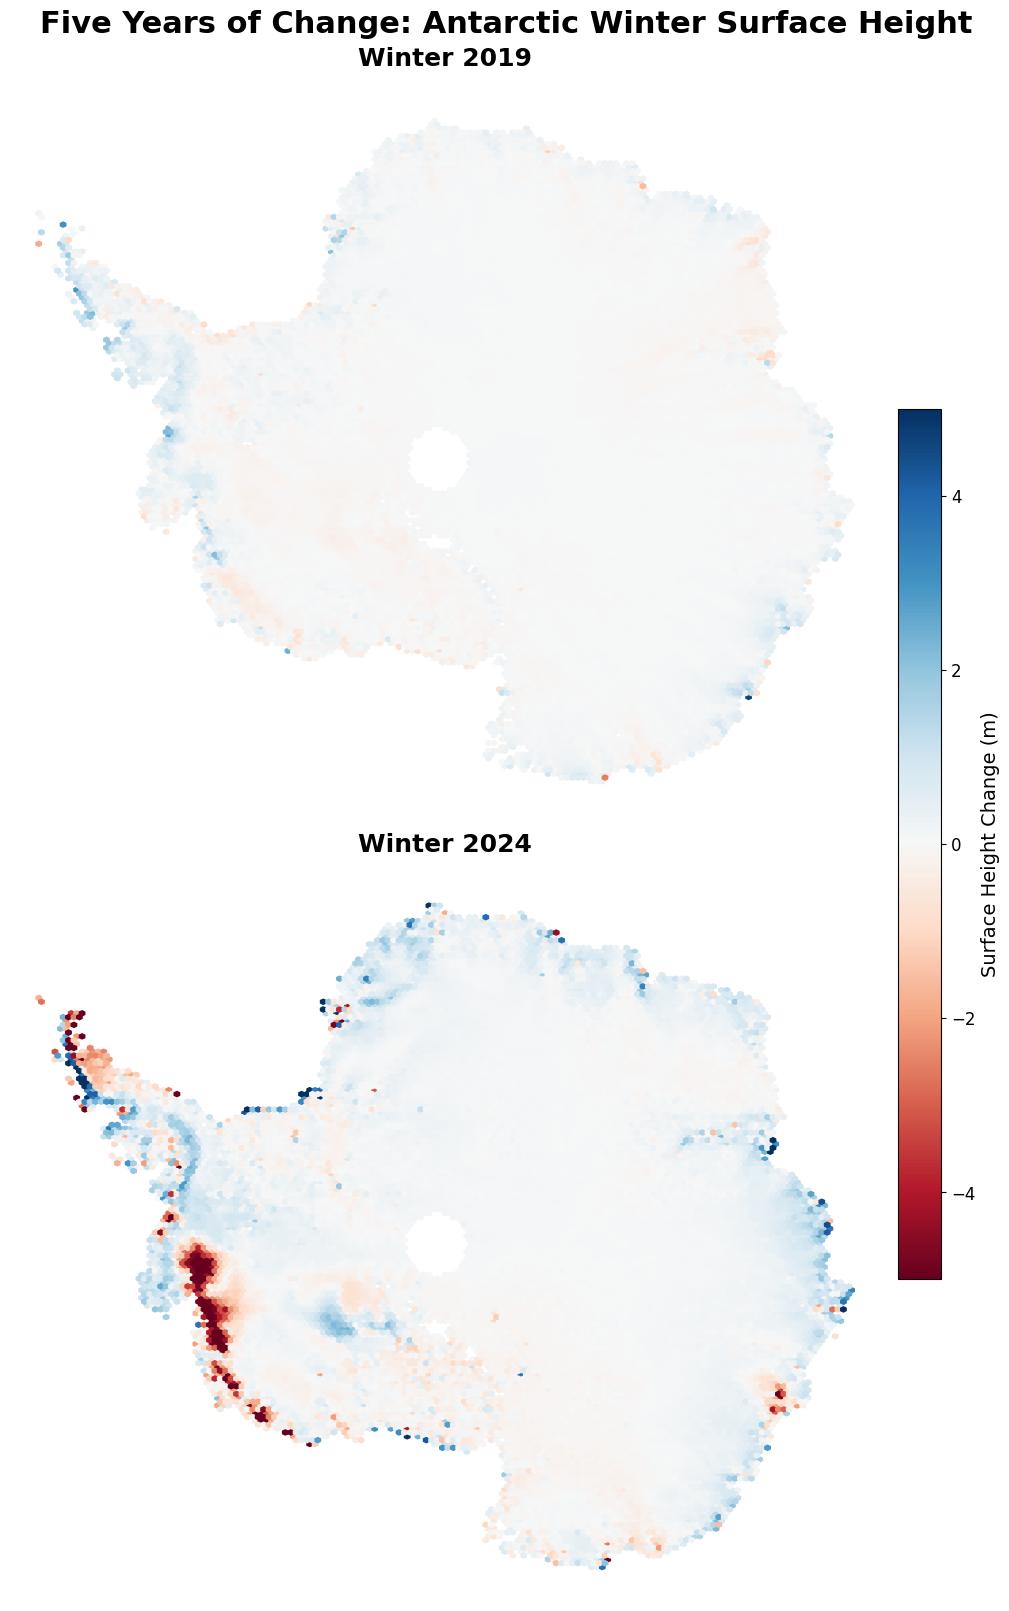

In [30]:
# define winter months
winter_months = [6, 7, 8]

# subset 2019 winter
df_start = df.filter(
    (F.year("time") == 2019) & 
    (F.month("time").isin(winter_months))
).select("x", "y", "delta_h").dropna().sample(fraction=0.01, seed=42).toPandas()
print(f"2019 winter subset points: {len(df_start):,}")

# subset 2024 winter
df_end = df.filter(
    (F.year("time") == 2024) & 
    (F.month("time").isin(winter_months))
).select("x", "y", "delta_h").dropna().sample(fraction=0.01, seed=42).toPandas()
print(f"2024 winter subset points: {len(df_end):,}")

# fig for two rows one col
fig, axes = plt.subplots(2, 1, figsize=(10, 16), constrained_layout=True)

# setting for plot args
V_MIN, V_MAX = -5, 5
GRID = 150
CMAP = 'RdBu'

# plot 2019 top
hb1 = axes[0].hexbin(
    df_start['x'], df_start['y'], C=df_start['delta_h'],
    gridsize=GRID, cmap=CMAP, vmin=V_MIN, vmax=V_MAX, reduce_C_function=np.mean
)
axes[0].set_title("Winter 2019", fontsize=18, fontweight='bold', pad=15)
axes[0].axis('equal')
axes[0].axis('off')

# plot 2024 
hb2 = axes[1].hexbin(
    df_end['x'], df_end['y'], C=df_end['delta_h'],
    gridsize=GRID, cmap=CMAP, vmin=V_MIN, vmax=V_MAX, reduce_C_function=np.mean
)
axes[1].set_title("Winter 2024", fontsize=18, fontweight='bold', pad=15)
axes[1].axis('equal')
axes[1].axis('off')

# add shared colorbar on the right
cbar = fig.colorbar(hb1, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Surface Height Change (m)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.suptitle("Five Years of Change: Antarctic Winter Surface Height", fontsize=22, fontweight='bold')
plt.show()